<a href="https://colab.research.google.com/github/Codebyjanhvi/Bilateral-Debt/blob/main/Wold_Bank_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests



In [ ]:
#Load base data
file_path = "/content/Data_Extract_From_International_Debt_Statistics_new.csv"
df_base = pd.read_csv(file_path)
print('Loaded dataset:')
print(file_path)
print('Shape:')
print(df_base.shape)


Loaded dataset:
/content/Data_Extract_From_International_Debt_Statistics_new.csv
Shape:
(630, 7)


In [ ]:
# Basic cleaning ---
df = df_base.copy()
cols_map = {c: c.strip() for c in df.columns}
df.rename(columns=cols_map, inplace=True)


In [ ]:
if 'Year' in df.columns:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
if 'Value' in df.columns:
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
print('Head:')
print(df.head(8))
print('Missingness (%):')
print((df.isna().mean()*100).round(1).sort_values(ascending=False))

Head:
  Country Name      Region         Income Group  Year  \
0        India  South Asia  Lower-middle income  2000   
1        India  South Asia  Lower-middle income  2000   
2        India  South Asia  Lower-middle income  2000   
3        India  South Asia  Lower-middle income  2001   
4        India  South Asia  Lower-middle income  2001   
5        India  South Asia  Lower-middle income  2001   
6        India  South Asia  Lower-middle income  2002   
7        India  South Asia  Lower-middle income  2002   

                          Series Name     Series Code       Value  
0  External debt stocks (current US$)  DT.DOD.DECT.CD   341007677  
1          Debt service (current US$)  DT.TDS.DECT.CD  1677640410  
2  Principal repayments (current US$)   DT.PR.PAYM.CD  1207974190  
3  External debt stocks (current US$)  DT.DOD.DECT.CD   736104015  
4          Debt service (current US$)  DT.TDS.DECT.CD   178051444  
5  Principal repayments (current US$)   DT.PR.PAYM.CD  1209446818  
6  E

In [ ]:
# Country data from World Bank API (region, income group)
wb_countries = []
page = 1
while True:
    url = 'https://api.worldbank.org/v2/country?format=json&per_page=300&page=' + str(page)
    r = requests.get(url, timeout=30)
    if r.status_code != 200:
        break
    data = r.json()
    if not isinstance(data, list) or len(data) < 2:
        break
    wb_countries.extend(data[1])
    if page >= data[0]['pages']:
        break
    page += 1

meta = pd.json_normalize(wb_countries)
# Keep key columns
keep_cols = {
    'id':'Country Code',
    'name':'WB Country Name',
    'region.value':'Region',
    'incomeLevel.value':'Income Group'
}
meta = meta[list(keep_cols.keys())].rename(columns=keep_cols)


In [ ]:
# Try to merge using Country Code if present, else fall back to name match
merge_on_code = 'Country Code' in df.columns
if merge_on_code:
    df_enriched = df.merge(meta, on='Country Code', how='left')
else:

    left_name_col = 'Country Name' if 'Country Name' in df.columns else None
    if left_name_col is None:
        df_enriched = df.copy()
        df_enriched['Region'] = np.nan
        df_enriched['Income Group'] = np.nan
    else:
        df_enriched = df.merge(meta, left_on=left_name_col, right_on='WB Country Name', how='left')

        df_enriched.drop(columns=['WB Country Name'], inplace=True)

# Handle duplicate columns after merge Drop the original columns and rename the merged ones
if 'Region_x' in df_enriched.columns:
    df_enriched.drop(columns=['Region_x', 'Income Group_x'], inplace=True)
    df_enriched.rename(columns={'Region_y': 'Region', 'Income Group_y': 'Income Group'}, inplace=True)


print('Enriched head:')
print(df_enriched.head(8))

Enriched head:
  Country Name  Year                         Series Name     Series Code  \
0        India  2000  External debt stocks (current US$)  DT.DOD.DECT.CD   
1        India  2000          Debt service (current US$)  DT.TDS.DECT.CD   
2        India  2000  Principal repayments (current US$)   DT.PR.PAYM.CD   
3        India  2001  External debt stocks (current US$)  DT.DOD.DECT.CD   
4        India  2001          Debt service (current US$)  DT.TDS.DECT.CD   
5        India  2001  Principal repayments (current US$)   DT.PR.PAYM.CD   
6        India  2002  External debt stocks (current US$)  DT.DOD.DECT.CD   
7        India  2002          Debt service (current US$)  DT.TDS.DECT.CD   

        Value Country Code      Region         Income Group  
0   341007677          IND  South Asia  Lower middle income  
1  1677640410          IND  South Asia  Lower middle income  
2  1207974190          IND  South Asia  Lower middle income  
3   736104015          IND  South Asia  Lower middle

In [ ]:
#Country and series coverage
coverage_country = df_enriched.groupby('Country Name').size().reset_index(name='rows').sort_values('rows', ascending=False)
coverage_series = df_enriched.groupby('Series Name').size().reset_index(name='rows').sort_values('rows', ascending=False)
print('Top 10 countries by rows:')
print(coverage_country.head(10))
print('Top 10 series by rows:')
print(coverage_series.head(10))


Top 10 countries by rows:
   Country Name  rows
0     Australia    63
1        Brazil    63
2         China    63
3       Germany    63
4         India    63
5         Japan    63
6        Mexico    63
7       Nigeria    63
8  South Africa    63
9           USA    63
Top 10 series by rows:
                          Series Name  rows
0          Debt service (current US$)   210
1  External debt stocks (current US$)   210
2  Principal repayments (current US$)   210


In [ ]:
#Time trends (pivot wide on series)
piv = df_enriched.pivot_table(index=['Country Name','Year','Region','Income Group'],
                              columns='Series Name', values='Value', aggfunc='mean').reset_index()
print('Pivoted head:')
print(piv.head(6))



Pivoted head:
Series Name Country Name  Year               Region Income Group  \
0              Australia  2000  East Asia & Pacific  High income   
1              Australia  2001  East Asia & Pacific  High income   
2              Australia  2002  East Asia & Pacific  High income   
3              Australia  2003  East Asia & Pacific  High income   
4              Australia  2004  East Asia & Pacific  High income   
5              Australia  2005  East Asia & Pacific  High income   

Series Name  Debt service (current US$)  External debt stocks (current US$)  \
0                          1.763512e+09                        1.062597e+09   
1                          1.992870e+09                        1.066628e+09   
2                          2.901940e+08                        1.054612e+09   
3                          6.081970e+08                        1.927025e+09   
4                          1.034518e+08                        1.294579e+09   
5                          1.376103

In [ ]:
#Identify core series
core_series = [
    'External debt stocks (current US$)',
    'Debt service (current US$)',
    'Principal repayments (current US$)'
]
existing_core = [s for s in core_series if s in piv.columns]
print('Core series present:')
print(existing_core)



Core series present:
['External debt stocks (current US$)', 'Debt service (current US$)', 'Principal repayments (current US$)']


In [ ]:
# Countrywise dept: region & income group
latest_year = piv.groupby('Country Name')['Year'].max().reset_index().rename(columns={'Year':'Latest Year'})
latest = latest_year.merge(piv, left_on=['Country Name','Latest Year'], right_on=['Country Name','Year'], how='left')
latest.drop(columns=['Year'], inplace=True)

latest_cols = ['Country Name','Latest Year','Region','Income Group'] + existing_core
latest_out = latest[latest_cols].copy()



In [ ]:
# YoY for core series
for s in existing_core:
    yoy_col = s + ' YoY%'
    piv[yoy_col] = piv.sort_values('Year').groupby('Country Name')[s].pct_change()



In [ ]:
# Regional and income aggregates (latest year per country, average by group)
reg_agg = latest_out.groupby('Region')[existing_core].mean().reset_index()
inc_agg = latest_out.groupby('Income Group')[existing_core].mean().reset_index()



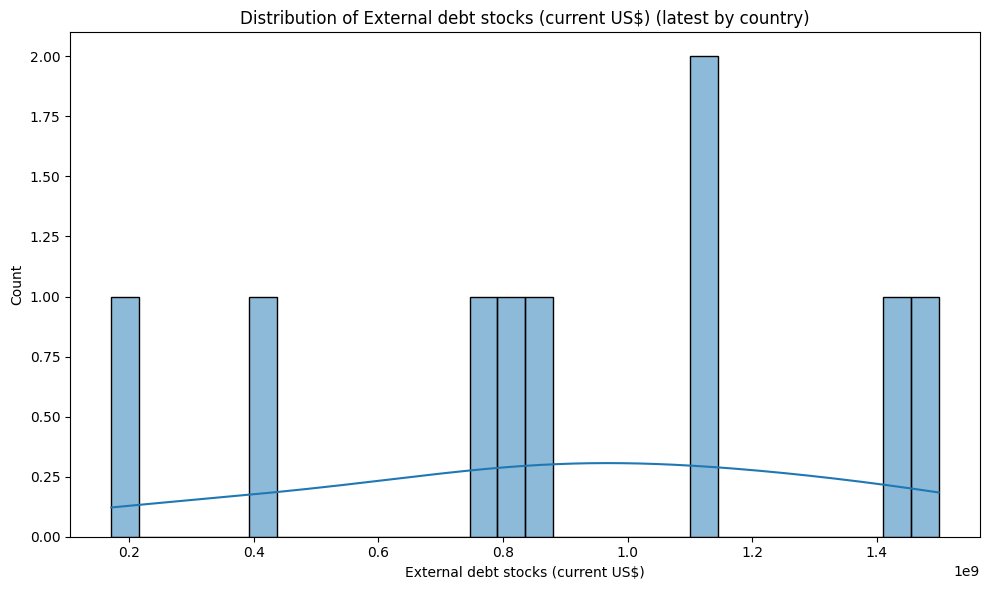

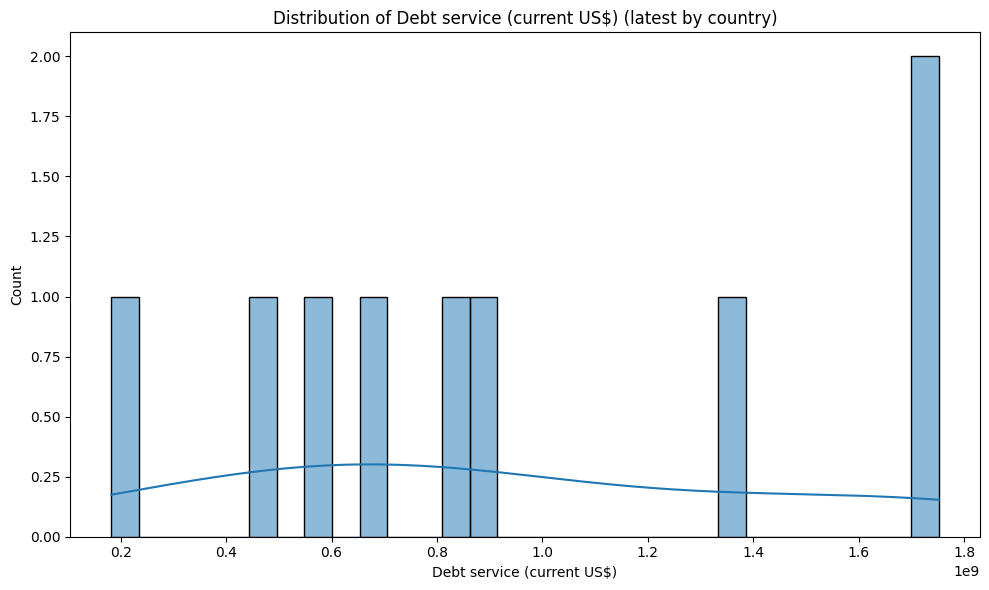

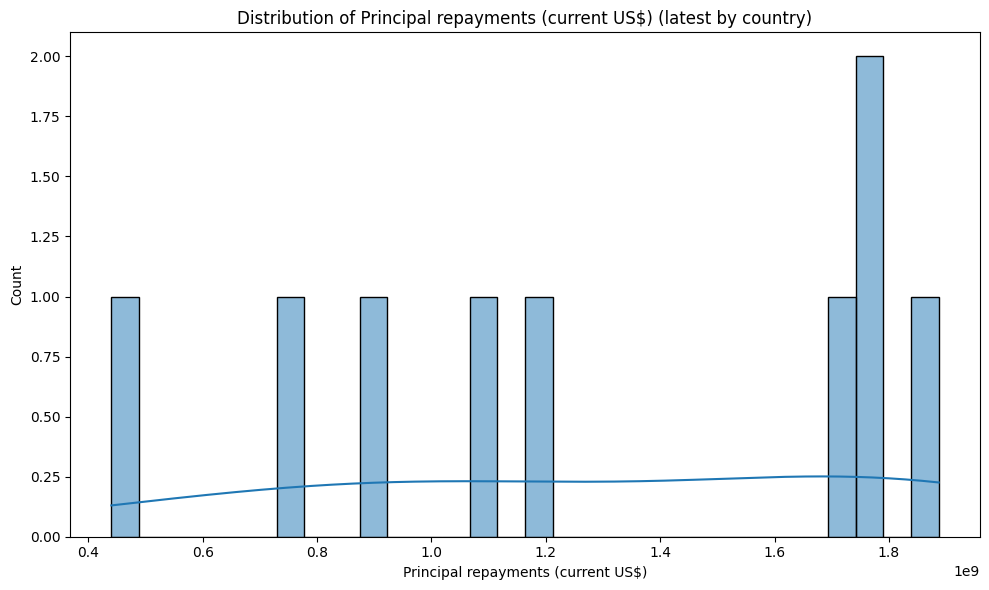

In [ ]:

# Distribution of values by core series (latest snapshot)
for s in existing_core:
    plt.figure(figsize=(10,6))
    sns.histplot(latest_out[s].dropna(), bins=30, kde=True)
    plt.title('Distribution of ' + s + ' (latest by country)')
    plt.xlabel(s)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()



/tmp/ipython-input-125525369.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reg_agg.sort_values('External debt stocks (current US$)', ascending=False),


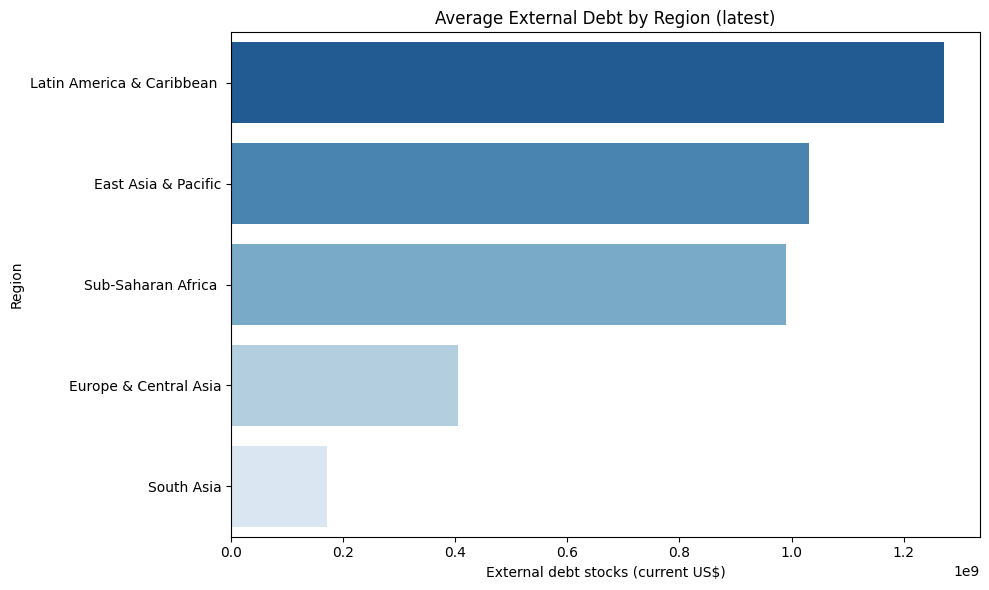

In [ ]:
# Regional bars for External Debt (if present)
if 'External debt stocks (current US$)' in existing_core:
    plt.figure(figsize=(10,6))
    sns.barplot(data=reg_agg.sort_values('External debt stocks (current US$)', ascending=False),
                x='External debt stocks (current US$)', y='Region', palette='Blues_r')
    plt.title('Average External Debt by Region (latest)')
    plt.xlabel('External debt stocks (current US$)')
    plt.ylabel('Region')
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-3166809988.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=inc_agg.sort_values('Debt service (current US$)', ascending=False),


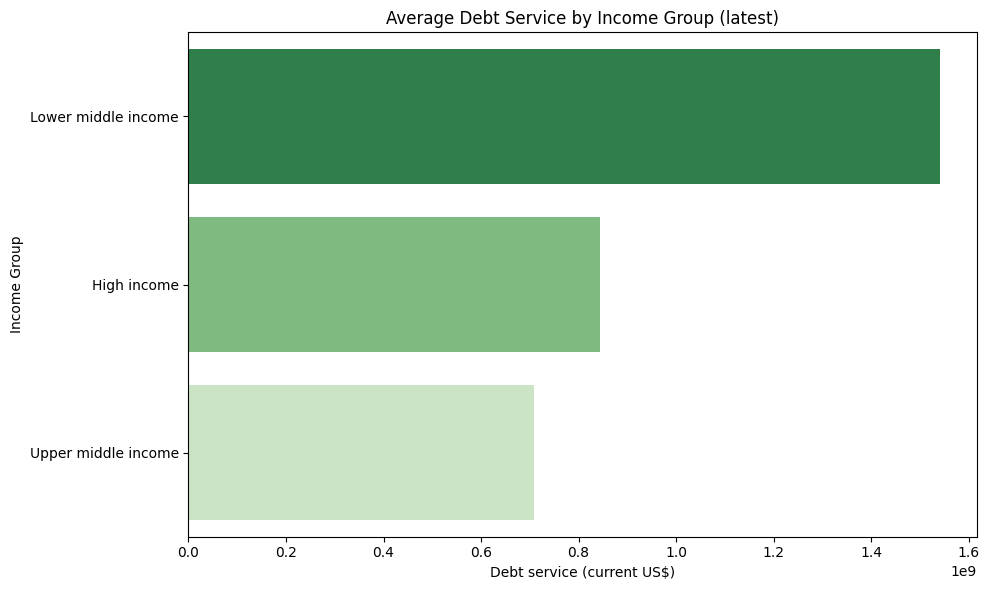

In [ ]:
# Income group bars for Debt service
if 'Debt service (current US$)' in existing_core:
    plt.figure(figsize=(10,6))
    sns.barplot(data=inc_agg.sort_values('Debt service (current US$)', ascending=False),
                x='Debt service (current US$)', y='Income Group', palette='Greens_r')
    plt.title('Average Debt Service by Income Group (latest)')
    plt.xlabel('Debt service (current US$)')
    plt.ylabel('Income Group')
    plt.tight_layout()
    plt.show()


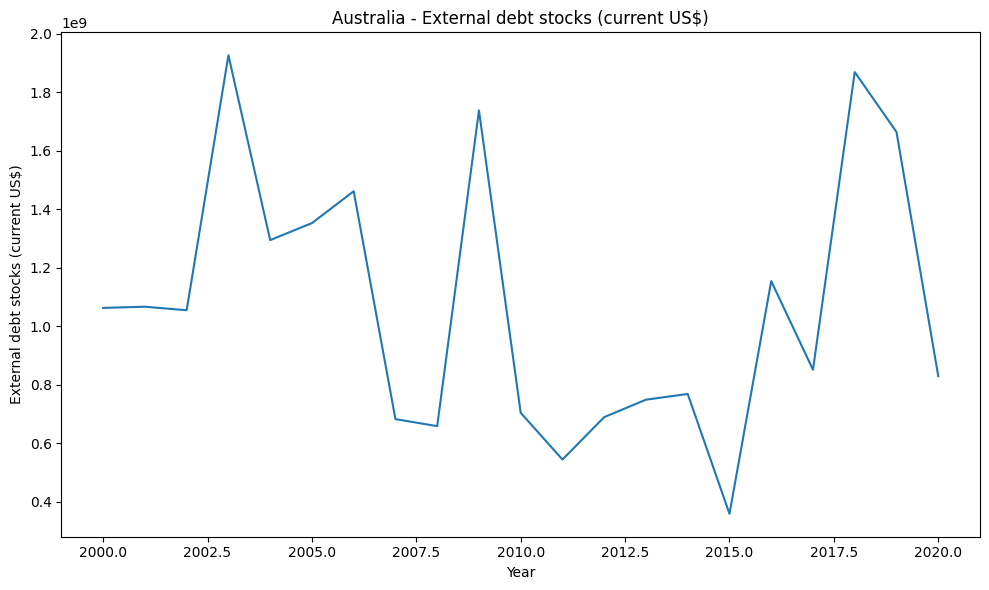

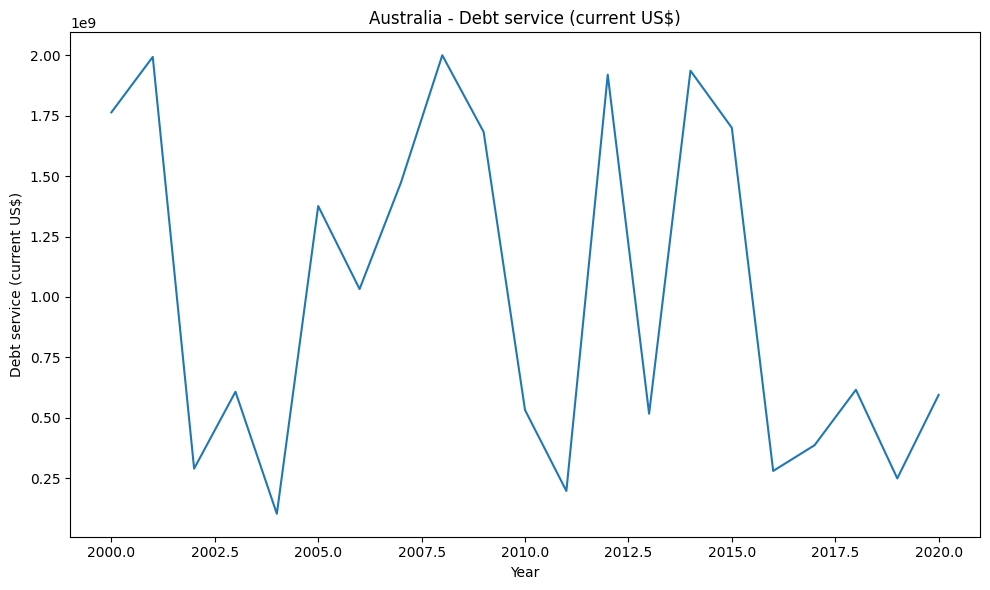

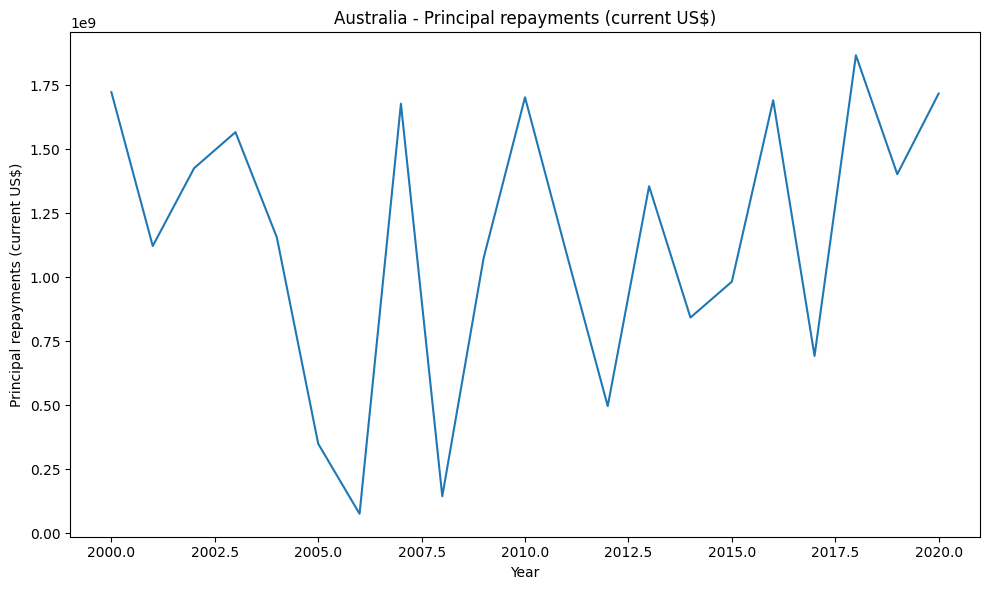

In [ ]:
# Example time series for the country with most rows
top_country = coverage_country.iloc[0]['Country Name'] if len(coverage_country) else None
if top_country is not None and len(existing_core) > 0:
    cts = piv[piv['Country Name'] == top_country].sort_values('Year')
    for s in existing_core:
        plt.figure(figsize=(10,6))
        sns.lineplot(data=cts, x='Year', y=s)
        plt.title(top_country + ' - ' + s)
        plt.xlabel('Year')
        plt.ylabel(s)
        plt.tight_layout()
        plt.show()



In [ ]:

eda_profile = piv[['Country Name','Year','Region','Income Group'] + existing_core].copy()
eda_profile_file = 'eda_profile_compact_enriched.csv'
eda_profile.to_csv(eda_profile_file, index=False)
print('Saved:')
print(eda_profile_file)

latest_file = 'eda_latest_snapshot_enriched.csv'
latest_out.to_csv(latest_file, index=False)
print('Saved:')
print(latest_file)

reg_file = 'eda_region_aggregates_latest.csv'
reg_agg.to_csv(reg_file, index=False)
print('Saved:')
print(reg_file)

inc_file = 'eda_income_aggregates_latest.csv'
inc_agg.to_csv(inc_file, index=False)
print('Saved:')
print(inc_file)

Saved:
eda_profile_compact_enriched.csv
Saved:
eda_latest_snapshot_enriched.csv
Saved:
eda_region_aggregates_latest.csv
Saved:
eda_income_aggregates_latest.csv
